## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [2]:
# Generate synthetic dataset
np.random.seed(1)
N = 10000
M = 10
K = 2
EDGE_PROB=1.0
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)



(0, 1)   [0.92256582 0.51148433]
(0, 2)   [0.48762871 0.94521501]
(1, 1)   [0.80055031 0.74437346]
(1, 2)   [0.82248175 0.18352073]
(2, 1)   [0.56633729 0.87851823]
(2, 2)   [0.84623222 0.84664302]
(3, 1)   [0.34574498 0.15331888]
(3, 2)   [0.70347524 0.63375897]
(4, 1)   [0.70448869 0.47060909]
(4, 2)   [0.27779581 0.36066668]
(5, 1)   [0.22790812 0.80498303]
(5, 2)   [0.47128496 0.13075418]
(6, 1)   [0.66162699 0.69457216]
(6, 2)   [0.36864577 0.50152106]
(7, 1)   [0.29991209 0.16602775]
(7, 2)   [0.52231467 0.18655503]
(8, 1)   [0.91303315 0.20754142]
(8, 2)   [0.57231944 0.1752607 ]
(9, 1)   [0.9251752  0.91940354]
(9, 2)   [0.3690371  0.62595021]
((0, 1), 1, 1)   [0.60932082 0.65254449]
((0, 1), 1, 2)   [0.96088209 0.33488108]
((0, 1), 2, 1)   [0.30791388 0.58010364]
((0, 1), 2, 2)   [0.95494432 0.54375363]
((1, 2), 1, 1)   [0.58654046 0.78893659]
((1, 2), 1, 2)   [0.14081116 0.22596951]
((1, 2), 2, 1)   [0.81316323 0.12682122]
((1, 2), 2, 2)   [0.89481293 0.58670937]
((0, 3), 1, 

P(L_ 1 = 0 , L_ 3 = 1  | Y =  1 ) =  0.023941825012383323
P(L_ 1 = 0 , L_ 3 = 2  | Y =  1 ) =  0.025440002670452395
P(L_ 1 = 1 , L_ 3 = 0  | Y =  1 ) =  0.02739110334323508
P(L_ 1 = 1 , L_ 3 = 1  | Y =  1 ) =  0.11818100820689492
P(L_ 1 = 1 , L_ 3 = 2  | Y =  1 ) =  0.12543332053060682
P(L_ 1 = 2 , L_ 3 = 0  | Y =  1 ) =  0.06660012385243398
P(L_ 1 = 2 , L_ 3 = 1  | Y =  1 ) =  0.294962347085544
P(L_ 1 = 2 , L_ 3 = 2  | Y =  1 ) =  0.31245917457390515
Labelers =  (1, 4)
P(L_ 1 = 0 , L_ 4 = 0  | Y =  1 ) =  0.0060450301739202504
P(L_ 1 = 0 , L_ 4 = 1  | Y =  1 ) =  0.02154587503702306
P(L_ 1 = 0 , L_ 4 = 2  | Y =  1 ) =  0.027382017196436622
P(L_ 1 = 1 , L_ 4 = 0  | Y =  1 ) =  0.029766592544020008
P(L_ 1 = 1 , L_ 4 = 1  | Y =  1 ) =  0.10386309390092835
P(L_ 1 = 1 , L_ 4 = 2  | Y =  1 ) =  0.13737574563578847
P(L_ 1 = 2 , L_ 4 = 0  | Y =  1 ) =  0.07175513486810133
P(L_ 1 = 2 , L_ 4 = 1  | Y =  1 ) =  0.26362751289452707
P(L_ 1 = 2 , L_ 4 = 2  | Y =  1 ) =  0.33863899774925477
Labelers

P(L_ 4 = 2 , L_ 7 = 0  | Y =  1 ) =  0.08657453129463706
P(L_ 4 = 2 , L_ 7 = 1  | Y =  1 ) =  0.23247989102220679
P(L_ 4 = 2 , L_ 7 = 2  | Y =  1 ) =  0.184342338264636
Labelers =  (4, 8)
P(L_ 4 = 0 , L_ 8 = 0  | Y =  1 ) =  0.01382054152267628
P(L_ 4 = 0 , L_ 8 = 1  | Y =  1 ) =  0.06137682680093568
P(L_ 4 = 0 , L_ 8 = 2  | Y =  1 ) =  0.03236938926242964
P(L_ 4 = 1 , L_ 8 = 0  | Y =  1 ) =  0.04988167960516181
P(L_ 4 = 1 , L_ 8 = 1  | Y =  1 ) =  0.22212963388263723
P(L_ 4 = 1 , L_ 8 = 2  | Y =  1 ) =  0.11702516834467945
P(L_ 4 = 2 , L_ 8 = 0  | Y =  1 ) =  0.06459069577778812
P(L_ 4 = 2 , L_ 8 = 1  | Y =  1 ) =  0.2873576445521735
P(L_ 4 = 2 , L_ 8 = 2  | Y =  1 ) =  0.15144842025151825
Labelers =  (4, 9)
P(L_ 4 = 0 , L_ 9 = 0  | Y =  1 ) =  0.01813638689832147
P(L_ 4 = 0 , L_ 9 = 1  | Y =  1 ) =  0.0563844711836837
P(L_ 4 = 0 , L_ 9 = 2  | Y =  1 ) =  0.03304589950403641
P(L_ 4 = 1 , L_ 9 = 0  | Y =  1 ) =  0.06558885025981166
P(L_ 4 = 1 , L_ 9 = 1  | Y =  1 ) =  0.203912635884299

P(L_ 1 = 0 , L_ 8 = 2  | Y =  2 ) =  0.04143938915337966
P(L_ 1 = 1 , L_ 8 = 0  | Y =  2 ) =  0.1442021846097643
P(L_ 1 = 1 , L_ 8 = 1  | Y =  2 ) =  0.2265211927689233
P(L_ 1 = 1 , L_ 8 = 2  | Y =  2 ) =  0.2605262706629756
P(L_ 1 = 2 , L_ 8 = 0  | Y =  2 ) =  0.061269877738988995
P(L_ 1 = 2 , L_ 8 = 1  | Y =  2 ) =  0.09621573283218161
P(L_ 1 = 2 , L_ 8 = 2  | Y =  2 ) =  0.11083538343300266
Labelers =  (1, 9)
P(L_ 1 = 0 , L_ 9 = 0  | Y =  2 ) =  0.011839037015298676
P(L_ 1 = 0 , L_ 9 = 1  | Y =  2 ) =  0.04331249924036644
P(L_ 1 = 0 , L_ 9 = 2  | Y =  2 ) =  0.04527782169849838
P(L_ 1 = 1 , L_ 9 = 0  | Y =  2 ) =  0.0745970443392745
P(L_ 1 = 1 , L_ 9 = 1  | Y =  2 ) =  0.28029548053527026
P(L_ 1 = 1 , L_ 9 = 2  | Y =  2 ) =  0.27635712316711836
P(L_ 1 = 2 , L_ 9 = 0  | Y =  2 ) =  0.030766051655016523
P(L_ 1 = 2 , L_ 9 = 1  | Y =  2 ) =  0.11251186376571849
P(L_ 1 = 2 , L_ 9 = 2  | Y =  2 ) =  0.12504307858343822
Labelers =  (2, 3)
P(L_ 2 = 0 , L_ 3 = 0  | Y =  2 ) =  0.005112796847

P(L_ 6 = 1 , L_ 8 = 2  | Y =  2 ) =  0.19461216297176268
P(L_ 6 = 2 , L_ 8 = 0  | Y =  2 ) =  0.09339064864054622
P(L_ 6 = 2 , L_ 8 = 1  | Y =  2 ) =  0.14667795902997255
P(L_ 6 = 2 , L_ 8 = 2  | Y =  2 ) =  0.16876880956528947
Labelers =  (6, 9)
P(L_ 6 = 0 , L_ 9 = 0  | Y =  2 ) =  0.014276374198403191
P(L_ 6 = 0 , L_ 9 = 1  | Y =  2 ) =  0.05203914164442935
P(L_ 6 = 0 , L_ 9 = 2  | Y =  2 ) =  0.05340290301162052
P(L_ 6 = 1 , L_ 9 = 0  | Y =  2 ) =  0.055253666102935216
P(L_ 6 = 1 , L_ 9 = 1  | Y =  2 ) =  0.20634070842217173
P(L_ 6 = 1 , L_ 9 = 2  | Y =  2 ) =  0.20984978938463167
P(L_ 6 = 2 , L_ 9 = 0  | Y =  2 ) =  0.04767209270825129
P(L_ 6 = 2 , L_ 9 = 1  | Y =  2 ) =  0.17773999347475408
P(L_ 6 = 2 , L_ 9 = 2  | Y =  2 ) =  0.18342533105280276
Labelers =  (7, 8)
P(L_ 7 = 0 , L_ 8 = 0  | Y =  2 ) =  0.04604619095659611
P(L_ 7 = 0 , L_ 8 = 1  | Y =  2 ) =  0.07231929016496216
P(L_ 7 = 0 , L_ 8 = 2  | Y =  2 ) =  0.0832114910273368
P(L_ 7 = 1 , L_ 8 = 0  | Y =  2 ) =  0.1028926114

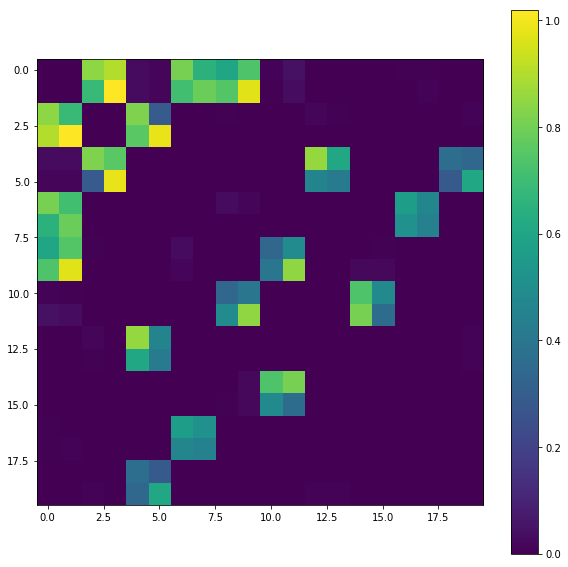

In [14]:
# mask the diagonals so we don't get influenced by them unfairly
sg_no_diag = np.copy(data.sig_inv)
for i in range(M):
    sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])

visualize_matrix(np.abs(sg_no_diag))

### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [4]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [5]:
lm.config['higher_order_cliques'] = True

In [6]:
'''# Generate the "correct" mu
lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)

# Compute O, O_inv, P based on L
lm._generate_O(data.L.todense())
O = lm.O.numpy()
print(O)
d, d = O.shape
O_inv = np.linalg.inv(O)
P = np.diag(data.p)

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T'''

'# Generate the "correct" mu\nlm._set_constants(data.L)\nlm._set_dependencies(data.E)\nmu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)\n\n# Compute O, O_inv, P based on L\nlm._generate_O(data.L.todense())\nO = lm.O.numpy()\nprint(O)\nd, d = O.shape\nO_inv = np.linalg.inv(O)\nP = np.diag(data.p)\n\nJJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)\nZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T'

In [7]:
# Check that JJT is indeed PSD ==> ZZT is rank k
#np.linalg.eig(JJT)[0]

In [8]:
#np.linalg.eig((ZZT + ZZT.T)/2)[0]

In [9]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=1024,
    #O_inv=ZZT
)

lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)


# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
print(mu)
print(mu_est)
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

Computing O^{-1}...
Estimating Z...
[Epoch 0] Loss: 1265079.375000
[Epoch 5000] Loss: 14751.180664
[Epoch 10000] Loss: 14723.509766
[Epoch 15000] Loss: 14711.140625
[Epoch 20000] Loss: 14752.640625
[Epoch 25000] Loss: 14704.625000
[Epoch 30000] Loss: 14703.866211
[Epoch 35000] Loss: 14705.026367
[Epoch 40000] Loss: 14704.472656
[Epoch 45000] Loss: 14703.853516
[Epoch 49999] Loss: 14705.061523
Estimating \mu...
[Epoch 0] Loss: 1047.384521
[Epoch 5000] Loss: 0.000375
[Epoch 10000] Loss: 0.000089
[Epoch 15000] Loss: 0.000040
[Epoch 20000] Loss: 0.000022
[Epoch 25000] Loss: 0.000017
[Epoch 30000] Loss: 0.000014
[Epoch 35000] Loss: 0.000014
[Epoch 40000] Loss: 0.000013
[Epoch 45000] Loss: 0.000013
[Epoch 49999] Loss: 0.000013
[[0.50375252 0.39056645]
 [0.45908841 0.55807803]
 [0.26853377 0.62882962]
 [0.67783269 0.26338991]
 [0.49441699 0.52832268]
 [0.43565806 0.42539123]
 [0.43950211 0.31254133]
 [0.46750869 0.56226581]
 [0.3952041  0.49239586]
 [0.49606443 0.4004849 ]
 [0.30459455 0.5664

### Sanity check that the true $Z$ gets lower loss

In [10]:
sorted(np.linalg.eig(O)[0])[::-1]

NameError: name 'O' is not defined

In [ ]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

#### Seed=2

In [ ]:
visualize_matrix(mask)

In [ ]:
#visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
lm.c_data

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=1

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=0

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)
l import LabelModl import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,el
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]